#importing dataset from drive

In [ ]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#data split + keyframe generation

**the dataset consists of videos to train the model to detect the arson anomaly**

the data has been split in the ratio 80:20 where:
- 80% of the videos have been used to train
- 20% of the videos have been used to test

i.e
- 48(24 abnormal + 24 normal) : test dataset
- 12(6 abnormal + 6 normal) : train dataset

In [14]:
import os
from glob import glob

label = "normal "
src_dir = "/content/drive/MyDrive"
video_path_pattern = os.path.join(src_dir, label, "*.mp4")
video_files = glob(video_path_pattern)

print(f"Looking in: {video_path_pattern}")
print(f"Found {len(video_files)} video(s).")
print(video_files)


Looking in: /content/drive/MyDrive/normal /*.mp4
Found 30 video(s).
['/content/drive/MyDrive/normal /Normal_1.mp4', '/content/drive/MyDrive/normal /Normal_2.mp4', '/content/drive/MyDrive/normal /Normal_4.mp4', '/content/drive/MyDrive/normal /Normal_5.mp4', '/content/drive/MyDrive/normal /Normal_6.mp4', '/content/drive/MyDrive/normal /Normal_3.mp4', '/content/drive/MyDrive/normal /Normal_7.mp4', '/content/drive/MyDrive/normal /Normal_8.mp4', '/content/drive/MyDrive/normal /Normal_9.mp4', '/content/drive/MyDrive/normal /Normal_10.mp4', '/content/drive/MyDrive/normal /Normal_11.mp4', '/content/drive/MyDrive/normal /Normal_12.mp4', '/content/drive/MyDrive/normal /Normal_13.mp4', '/content/drive/MyDrive/normal /Normal_14.mp4', '/content/drive/MyDrive/normal /Normal_15.mp4', '/content/drive/MyDrive/normal /Normal_16.mp4', '/content/drive/MyDrive/normal /Normal_17.mp4', '/content/drive/MyDrive/normal /Normal_18.mp4', '/content/drive/MyDrive/normal /Normal_19.mp4', '/content/drive/MyDrive/norm

In [15]:
import os
import cv2
import shutil
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split


src_dir = '/content/drive/MyDrive'  # absolute path to drive root
out_base = '/content/drive/MyDrive/processed_dataset'
labels = ['normal ','arson']
frame_rate = 1

def extract_keyframes(video_path, output_dir, label, prefix):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps // frame_rate) if fps > 0 else 1
    frame_count = 0
    saved = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            filename = f"{prefix}_frame{saved}.jpg"
            save_path = os.path.join(output_dir, label, filename)
            cv2.imwrite(save_path, frame)
            saved += 1
        frame_count += 1
    cap.release()

for split in ['train', 'test']:
    for label in labels:
        os.makedirs(os.path.join(out_base, split, label), exist_ok=True)

for label in labels:
    video_files = sorted(glob(os.path.join(src_dir, label, "*.mp4")))
    if not video_files:
        print(f"No videos found in {label}. Skipping.")
        continue
    train_videos, test_videos = train_test_split(video_files, test_size=0.2, random_state=42)

    for video_path in tqdm(train_videos, desc=f"{label} - train"):
        prefix = os.path.splitext(os.path.basename(video_path))[0]
        extract_keyframes(video_path, os.path.join(out_base, 'train'), label, prefix)

    for video_path in tqdm(test_videos, desc=f"{label} - test"):
        prefix = os.path.splitext(os.path.basename(video_path))[0]
        extract_keyframes(video_path, os.path.join(out_base, 'test'), label, prefix)

print("✅ Step 1 complete: Keyframes extracted and dataset split.")


arson - test: 100%|██████████| 6/6 [00:11<00:00,  1.90s/it]

✅ Step 1 complete: Keyframes extracted and dataset split.


#preprocessing

In [16]:
import os
import cv2
import numpy as np
from tqdm import tqdm


In [20]:
def normalize_and_save_images(source_root, target_root):
    for split in ['train', 'test']:
        for category in ['arson', 'normal ']:
            source_path = os.path.join(source_root, split, category)
            target_path = os.path.join(target_root, split, category)
            os.makedirs(target_path, exist_ok=True)

            print(f"Normalizing from: {source_path} ➜ to: {target_path}")

            for filename in tqdm(os.listdir(source_path)):
                src_file = os.path.join(source_path, filename)
                dst_file = os.path.join(target_path, filename)

                try:
                    img = cv2.imread(src_file)

                    if img is None:
                        print(f"Skipping unreadable image: {src_file}")
                        continue

                    # Normalize image to [0, 1], then scale back to uint8
                    img = img.astype(np.float32) / 255.0
                    img = (img * 255).astype(np.uint8)

                    cv2.imwrite(dst_file, img)

                except Exception as e:
                    print(f"Error processing {src_file}: {e}")


In [21]:
# If on Google Colab with Drive mounted
source_root = '/content/drive/MyDrive/processed_dataset'
target_root = '/content/drive/MyDrive/normalized_dataset'

# Local use case
# source_root = './processed_dataset'
# target_root = './normalized_dataset'

normalize_and_save_images(source_root, target_root)


Normalizing from: /content/drive/MyDrive/processed_dataset/train/arson ➜ to: /content/drive/MyDrive/normalized_dataset/train/arson


100%|██████████| 789/789 [00:11<00:00, 67.90it/s]


Normalizing from: /content/drive/MyDrive/processed_dataset/train/normal  ➜ to: /content/drive/MyDrive/normalized_dataset/train/normal 


100%|██████████| 685/685 [00:11<00:00, 58.58it/s]


Normalizing from: /content/drive/MyDrive/processed_dataset/test/arson ➜ to: /content/drive/MyDrive/normalized_dataset/test/arson


100%|██████████| 182/182 [00:03<00:00, 52.60it/s]


Normalizing from: /content/drive/MyDrive/processed_dataset/test/normal  ➜ to: /content/drive/MyDrive/normalized_dataset/test/normal 


100%|██████████| 239/239 [00:03<00:00, 69.77it/s]


#YoloV7 inference

In [1]:
# Step 1: Delete any existing yolov7 directory
!rm -rf yolov7

In [2]:
!git clone https://github.com/WongKinYiu/yolov7.git
%cd yolov7


Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197 (from 1)
Receiving objects: 100% (1197/1197), 74.29 MiB | 19.25 MiB/s, done.
Resolving deltas: 100% (511/511), done.
/content/yolov7


In [3]:
!pip install -r requirements.txt
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q seaborn pycocotools


In [4]:
!mkdir -p weights

# Download the official YOLOv7 pretrained model
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt -O weights/yolov7.pt


--2025-07-22 17:53:54--  https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/511187726/b0243edf-9fb0-4337-95e1-42555f1b37cf?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-07-22T18%3A34%3A34Z&rscd=attachment%3B+filename%3Dyolov7.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-07-22T17%3A34%3A13Z&ske=2025-07-22T18%3A34%3A34Z&sks=b&skv=2018-11-09&sig=AmvJZGLyHqXbtVt0F3Vp8eyMckRcrcfnBmdWsQE%2FxgU%3D&jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1MzIwNzEzNSwibmJmIjoxNzUzMjA2ODM1LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNvcmUud2lu

In [5]:
!ls weights/
# Should show: yolov7.pt


yolov7.pt


In [6]:
import os
import json
import torch
from pathlib import Path
from models.experimental import attempt_load
from utils.datasets import LoadImages
from utils.general import non_max_suppression, scale_coords
from utils.torch_utils import select_device
from tqdm import tqdm

# Parameters
weights = 'weights/yolov7.pt'  # Make sure yolov7.pt is downloaded into 'weights/' directory
imgsz = 640
source = '/content/drive/MyDrive/processed_dataset/train'  # Directory containing 'arson' and 'normal' folders
output_json = 'train_features.json'

# Setup
device = select_device('' if torch.cuda.is_available() else 'cpu')

# Load checkpoint manually to fix PyTorch >= 2.6 compatibility
checkpoint = torch.load(weights, map_location=device, weights_only=False)
model = checkpoint['model'].float().fuse().to(device).eval()

data = {}

# Process each class folder
for label in ['arson', 'normal ']:
    label_path = os.path.join(source, label)
    dataset = LoadImages(label_path, img_size=imgsz)

    for path, img, im0s, vid_cap in tqdm(dataset, desc=f"Processing {label}"):
        img = torch.from_numpy(img).to(device).float() / 255.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        with torch.no_grad():
            pred = model(img)[0]
            pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45)[0]

        objects = []
        if pred is not None and len(pred):
            pred[:, :4] = scale_coords(img.shape[2:], pred[:, :4], im0s.shape).round()
            for *xyxy, conf, cls in pred:
                obj = {
                    'class_id': int(cls.item()),
                    'confidence': float(conf.item())
                }
                objects.append(obj)

        data[os.path.basename(path)] = {
            'label': label,
            'detections': objects
        }

# Save results to JSON
with open(output_json, 'w') as f:
    json.dump(data, f, indent=2)

print("✅ Inference complete. Features saved to:", output_json)



Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


/usr/local/lib/python3.11/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:950: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
Processing normal : 100%|██████████| 685/685 [00:23<00:00, 29.62it/s]

✅ Inference complete. Features saved to: train_features.json


#converting detection logs to sequences for LSTM

In [11]:
import numpy as np
import types

# Patch numpy to fake the missing 'dtypes' module
if not hasattr(np, 'dtypes'):
    np.dtypes = types.SimpleNamespace()

In [13]:
import os
print(os.listdir())


['data', 'scripts', 'LICENSE.md', 'models', 'export.py', 'hubconf.py', 'README.md', 'paper', 'weights', '.gitignore', 'test.py', '.git', 'train.py', 'train_aux.py', 'utils', 'tools', 'inference', 'requirements.txt', 'train_features.json', 'figure', 'cfg', 'detect.py', 'deploy']


In [14]:
import sys
import types

# Patch jax to avoid import errors
sys.modules['jax'] = types.SimpleNamespace()
sys.modules['jax'].version = types.SimpleNamespace()
sys.modules['jax'].version.__file__ = '/dev/null'

# Now import TensorFlow-related modules
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [15]:
import json
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load JSON
with open('train_features.json') as f:
    data = json.load(f)

# Group frames by video
videos = {}
all_frame_classes = []

for filename, info in data.items():
    video_id = filename.split('_frame')[0]
    cls_ids = [det['class_id'] for det in info['detections']]
    videos.setdefault(video_id, {'label': info['label'], 'frames': []})
    videos[video_id]['frames'].append(cls_ids)
    all_frame_classes.append(cls_ids)  # Collect all for global fit

# Fit ML Binarizer ONCE globally
mlb = MultiLabelBinarizer()
mlb.fit(all_frame_classes)

# Convert to binarized sequences
X, y = [], []

for vid_id, vid_info in videos.items():
    frame_vecs = mlb.transform(vid_info['frames'])  # Transform only
    X.append(frame_vecs)
    y.append(1 if vid_info['label'] == 'arson' else 0)

# Pad sequences to same length
X = pad_sequences(X, padding='post', maxlen=30, dtype='float32')
y = np.array(y)

print(f"✅ Step 3 complete: {len(X)} sequences ready for LSTM.")



✅ Step 3 complete: 48 sequences ready for LSTM.


LSTM model to detect arson ->

In [8]:
!pip show numpy


Name: numpy
Version: 1.23.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: 
Required-by: accelerate, albucore, albumentations, ale-py, arviz, astropy, autograd, bigframes, blis, blosc2, bokeh, Bottleneck, bqplot, chex, clarabel, cmdstanpy, contourpy, cudf-cu12, cufflinks, cuml-cu12, cupy-cuda12x, cuvs-cu12, cvxpy, cyipopt, dask-cuda, dask-cudf-cu12, datascience, datasets, db-dtypes, diffusers, dm-tree, dopamine_rl, flax, folium, geemap, geopandas, gradio, gym, gymnasium, h5py, hdbscan, highspy, holoviews, hyperopt, imageio, imbalanced-learn, jax, jaxlib, keras, keras-hub, libpysal, librosa, lightgbm, matplotlib, matplotlib-venn, missingno, mizani, ml-dtypes, mlxtend, moviepy, music21, nibabel, numba, numexpr, nx-cugraph-cu12, opencv-contrib-python, opencv-python, opencv-python-headless, optax, orbax-checkp

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.model_selection import train_test_split

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X.shape[1], X.shape[2])),
    LSTM(64, return_sequences=False, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
         kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros',
         unit_forget_bias=True, use_cudnn=False),  # 👈 explicitly disable CuDNN
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8)
print("✅ Step 4 complete: LSTM model trained.")



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 30, 44)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        27,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,017 (117.25 KB)

 Trainable params: 30,017 (117.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 703ms/step - accuracy: 0.5609 - loss: 0.7026 - val_accuracy: 0.4000 - val_loss: 0.7268
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6866 - loss: 0.6838 - val_accuracy: 0.7000 - val_loss: 0.6718
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7838 - loss: 0.6425 - val_accuracy: 0.7000 - val_loss: 0.6281
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7491 - loss: 0.6159 - val_accuracy: 0.7000 - val_loss: 0.5980
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7994 - loss: 0.5705 - val_accuracy: 0.6000 - val_loss: 0.5538
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7336 - loss: 0.5778 - val_accuracy: 0.7000 - val_loss: 0.5524
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7369 - loss: 0.5322 - val_accuracy: 0.7000 - val_loss: 0.5423
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8467 - loss: 0.5468 - val_accuracy: 0.8000 - val_loss: 0.5216

#evaluation metrics

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.75      1.00      0.86         3

    accuracy                           0.90        10
   macro avg       0.88      0.93      0.89        10
weighted avg       0.93      0.90      0.90        10

🔵 AUC: 0.8571
🟢 Precision: 0.7500
🟡 Recall: 1.0000
🟠 F1 Score: 0.8571
🟣 mAP (Average Precision): 0.6389


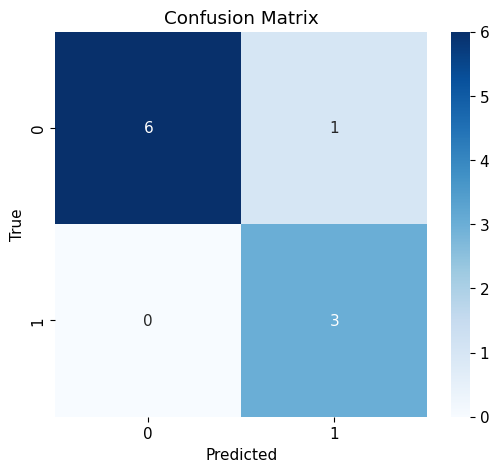

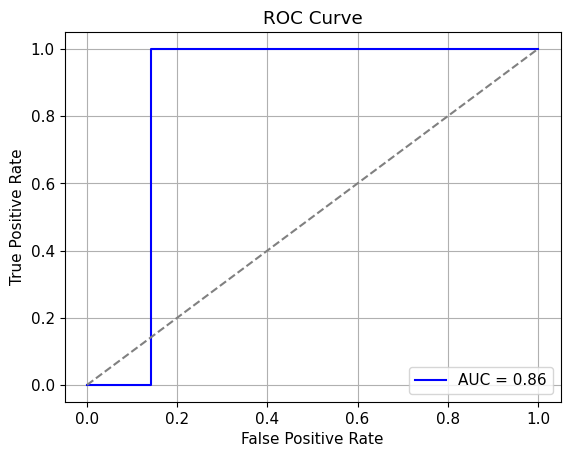

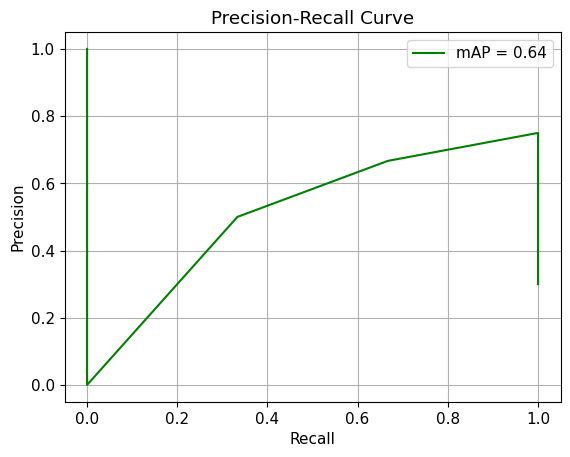

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, auc, f1_score
import seaborn as sns

# Predict probabilities and class labels
y_pred_probs = model.predict(X_val).ravel()
y_pred_classes = (y_pred_probs >= 0.5).astype(int)

# 📌 Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_classes))

# 📌 AUC
roc_auc = roc_auc_score(y_val, y_pred_probs)
print(f"🔵 AUC: {roc_auc:.4f}")

# 📌 Precision, Recall, F1
precision_val = precision_score(y_val, y_pred_classes)
recall_val = recall_score(y_val, y_pred_classes)
f1 = f1_score(y_val, y_pred_classes)
print(f"🟢 Precision: {precision_val:.4f}")
print(f"🟡 Recall: {recall_val:.4f}")
print(f"🟠 F1 Score: {f1:.4f}")

# 📌 mAP (Average Precision Score)
ap = average_precision_score(y_val, y_pred_probs)
print(f"🟣 mAP (Average Precision): {ap:.4f}")

# 📌 Confusion Matrix Plot
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 📌 ROC Curve Plot
fpr, tpr, _ = roc_curve(y_val, y_pred_probs)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# 📌 Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_val, y_pred_probs)
plt.figure()
plt.plot(rec, prec, color='green', label=f"mAP = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()




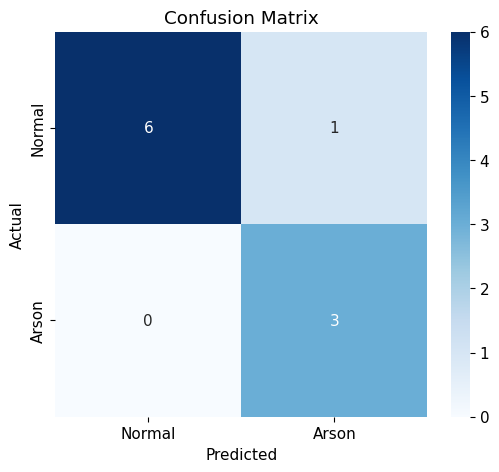

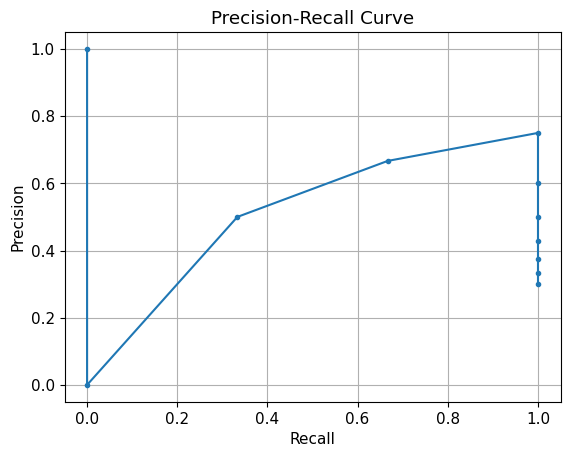

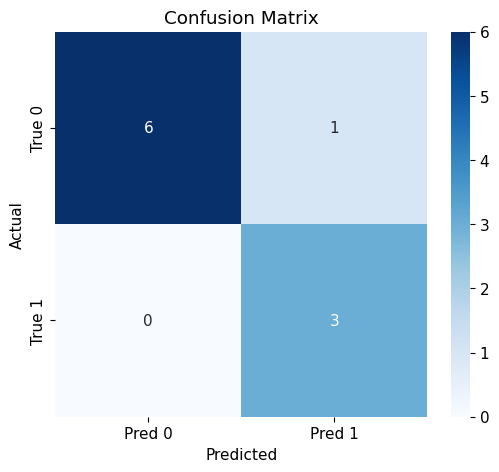

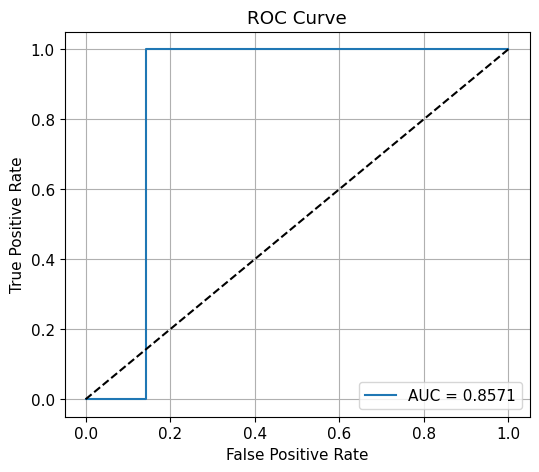

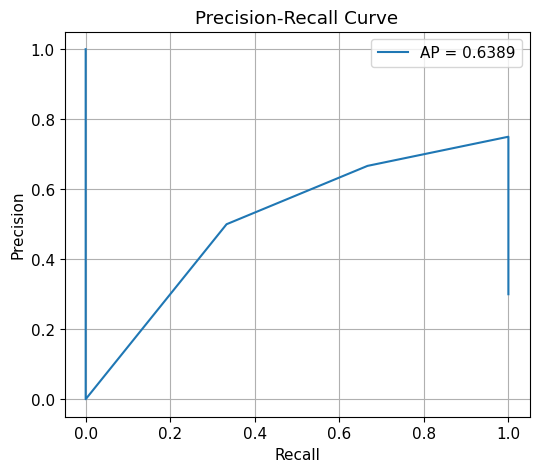

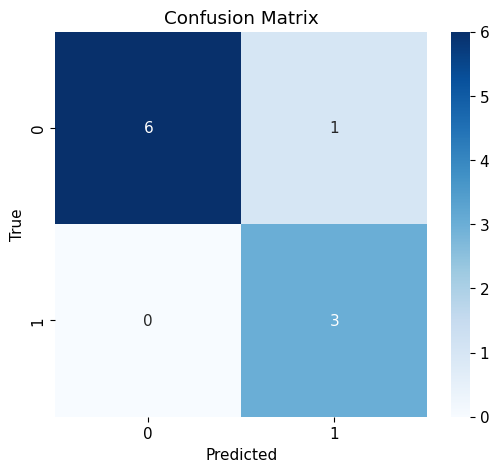

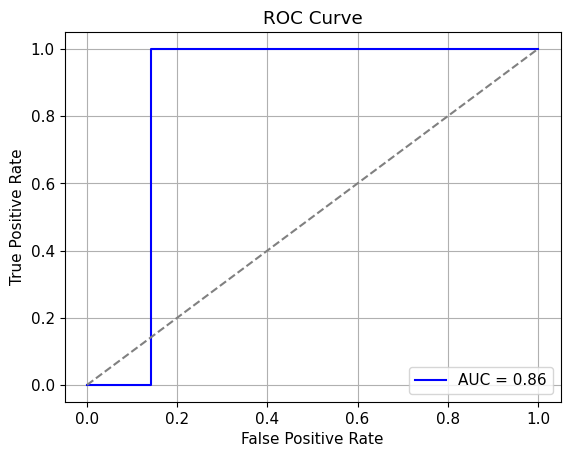

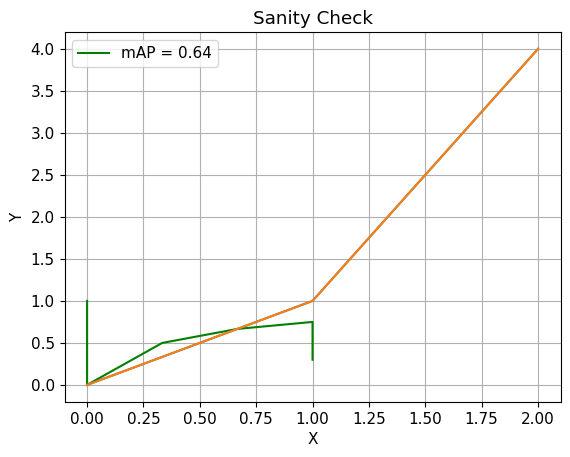

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([0, 1, 2], [0, 1, 4])
plt.title("Sanity Check")
plt.show()
